# Multi-representation Indexing

Summary Embeddingによる検索文章の要約  
チャンクはSemantic Chunking

https://qiita.com/shimajiroxyz/items/facf409b81f59bb68775

In [1]:
import os
import pandas as pd
import openai
import datetime
import tiktoken
import uuid
from sudachipy import tokenizer
from sudachipy import dictionary
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.storage import InMemoryStore
from langchain.docstore import InMemoryDocstore
from langchain.retrievers import MultiVectorRetriever
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [2]:
# OpenAI APIキーを設定
openai.api_key = input()

## テキスト読み込み

In [3]:
novel_file_path = "../data/novels_preprocess_2/works/"

In [4]:
# .txt ファイルを読み込み、ドキュメントをリスト化
documents = []
for filename in os.listdir(novel_file_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(novel_file_path, filename)
        loader = TextLoader(file_path, encoding="utf-8")
        documents.extend(loader.load())

In [5]:
documents

[Document(metadata={'source': '../data/novels_preprocess_2/works/カインの末裔.txt'}, page_content='（一）\n長い影を地にひいて、痩馬の手綱を取りながら、彼れは黙りこくって歩いた。\n大きな汚い風呂敷包と一緒に、章魚のように頭ばかり大きい赤坊をおぶった彼れの妻は、少し跛脚をひきながら三、四間も離れてその跡からとぼとぼとついて行った。\n北海道の冬は空まで逼っていた。\n蝦夷富士といわれるマッカリヌプリの麓に続く胆振の大草原を、日本海から内浦湾に吹きぬける西風が、打ち寄せる紆濤のように跡から跡から吹き払っていった。\n寒い風だ。\n見上げると八合目まで雪になったマッカリヌプリは少し頭を前にこごめて風に歯向いながら黙ったまま突立っていた。\n昆布岳の斜面に小さく集った雲の塊を眼がけて日は沈みかかっていた。\n草原の上には一本の樹木も生えていなかった。\n心細いほど真直な一筋道を、彼れと彼れの妻だけが、よろよろと歩く二本の立木のように動いて行った。\n二人は言葉を忘れた人のようにいつまでも黙って歩いた。\n馬が溺りをする時だけ彼れは不性無性に立どまった。\n妻はその暇にようやく追いついて背の荷をゆすり上げながら溜息をついた。\n馬が溺りをすますと二人はまた黙って歩き出した。\n「ここらおやじ（熊の事）が出るずら」\n四里にわたるこの草原の上で、たった一度妻はこれだけの事をいった。\n慣れたものには時刻といい、所柄といい熊の襲来を恐れる理由があった。\n彼れはいまいましそうに草の中に唾を吐き捨てた。\n草原の中の道がだんだん太くなって国道に続く所まで来た頃には日は暮れてしまっていた。\n物の輪郭が円味を帯びずに、堅いままで黒ずんで行くこちんとした寒い晩秋の夜が来た。\n着物は薄かった。\nそして二人は餓え切っていた。\n妻は気にして時々赤坊を見た。\n生きているのか死んでいるのか、とにかく赤坊はいびきも立てないで首を右の肩にがくりと垂れたまま黙っていた。\n国道の上にはさすがに人影が一人二人動いていた。\n大抵は市街地に出て一杯飲んでいたのらしく、行違いにしたたか酒の香を送ってよこすものもあった。\n彼れは酒の香をかぐと急にえぐられるような渇きと食欲とを覚えて、すれ違った男を見送ったりした

In [6]:
page_contents_list = [doc.page_content for doc in documents]
page_contents = "\n".join(page_contents_list)

In [7]:
sentences_list = page_contents.split("\n")

In [8]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(sentences_list)]
sentences[:3]

[{'sentence': '（一）', 'index': 0},
 {'sentence': '長い影を地にひいて、痩馬の手綱を取りながら、彼れは黙りこくって歩いた。', 'index': 1},
 {'sentence': '大きな汚い風呂敷包と一緒に、章魚のように頭ばかり大きい赤坊をおぶった彼れの妻は、少し跛脚をひきながら三、四間も離れてその跡からとぼとぼとついて行った。',
  'index': 2}]

In [9]:
len(sentences)

7750

## Embedding

In [10]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [11]:
# OpenAIの埋め込みモデルを使ってドキュメントをベクトル化
embedding = OpenAIEmbeddings(openai_api_key=openai.api_key)

C:\Users\tatsu\AppData\Local\Temp\ipykernel_29864\900527064.py:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  embedding = OpenAIEmbeddings(openai_api_key=openai.api_key)


In [12]:
embeddings = embedding.embed_documents([x['combined_sentence'] for x in sentences])

In [13]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

## 類似度比較

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [15]:
distances, sentences = calculate_cosine_distances(sentences)
distances[:3]

[0.051973627120077026, 0.026729114326370818, 0.04455227061023881]

### 類似度確認

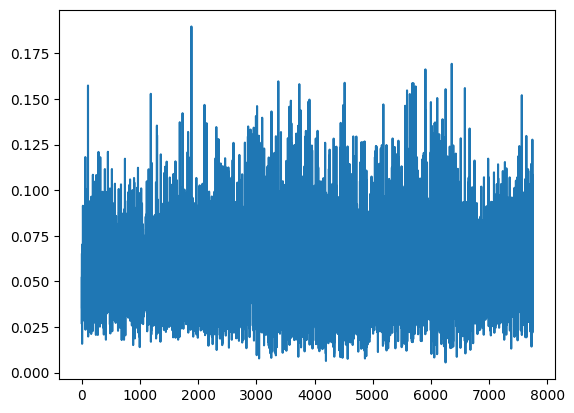

In [16]:
import matplotlib.pyplot as plt

plt.plot(distances)

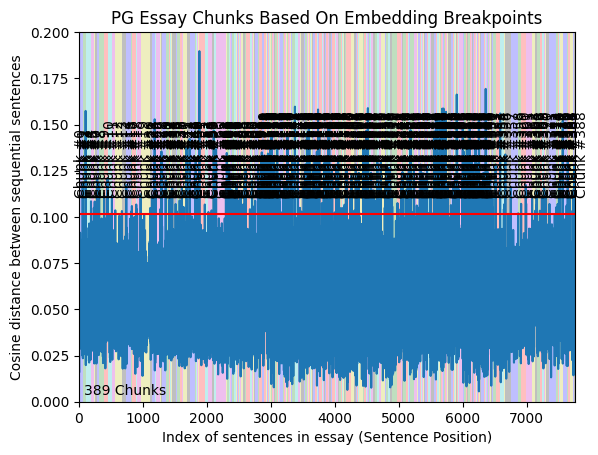

In [17]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

## チャンク分割

In [18]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

In [19]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
（一） 長い影を地にひいて、痩馬の手綱を取りながら、彼れは黙りこくって歩いた。 大きな汚い風呂敷包と一緒に、章魚のように頭ばかり大きい赤坊をおぶった彼れの妻は、少し跛脚をひきながら三、四間も離れてその跡からとぼとぼとついて行った。 北海道の冬は空まで逼っていた。 蝦夷富士といわれるマッカリヌプリの麓に続く胆振の大草原を、日本海から内浦湾に吹きぬける西風が、打ち寄せる紆濤のように跡から跡から吹き払っ
...
る時の事を思った。 妻は吸い取られるように暖かそうな火の色に見惚れていた。 二人は妙にわくわくした心持ちになった。 蹄鉄屋の先きは急に闇が濃かくなって大抵の家はもう戸じまりをしていた。 荒物屋を兼ねた居酒屋らしい一軒から食物の香と男女のふざけ返った濁声がもれる外には、真直な家並は廃村のように寒さの前にちぢこまって、電信柱だけが、けうとい唸りを立てていた。 彼れと馬と妻とは前の通りに押黙って歩いた。


Chunk #1
歩いては時折り思い出したように立停った。 立停ってはまた無意味らしく歩き出した。 四、五町歩いたと思うと彼らはもう町はずれに来てしまっていた。 道がへし折られたように曲って、その先きは、真闇な窪地に、急な勾配を取って下っていた。 彼らはその突角まで行ってまた立停った。 遙か下の方からは、うざうざするほど繁り合った濶葉樹林に風の這入る音の外に、シリベシ河のかすかな水の音だけが聞こえていた。 「聞いて
...
てた。 彼れはそれにも気を取られていた。 上框に腰をかけていたもう一人の男はやや暫らく彼れの顔を見つめていたが、浪花節語りのような妙に張りのある声で突然口を切った。 「お主は川森さんの縁のものじゃないんかの。どうやら顔が似とるじゃが」 今度は彼れの返事も待たずに長顔の男の方を向いて、 「帳場さんにも川森から話いたはずじゃがの。主がの血筋を岩田が跡に入れてもらいたいいうてな」 また彼れの方を向いて、




In [20]:
len(chunks)

389

## Summary Embedding

In [21]:
# OpenAIの言語モデルを設定（ここではGPT-3を使用）
# llm_mini = ChatOpenAI(model="gpt-4o-mini", openai_api_key=openai.api_key)
llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai.api_key)

C:\Users\tatsu\AppData\Local\Temp\ipykernel_29864\1360590322.py:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai.api_key)


### 検索用要約文章の作成

In [22]:
chain = (
    {"doc": lambda x: x}
    | ChatPromptTemplate.from_template("以下の文章を重要なキーワードは残して要約してください。:\n\n{doc}")
    | llm
    | StrOutputParser()
)

In [23]:
summaries = chain.batch(chunks, {"max_concurrency": 1})

In [24]:
summaries

['以下の文章を重要なキーワードは残して要約しました：\n\n北海道の冬、痩せた馬を引いて歩く男と、赤ん坊を背負いながら跛脚をひきつつ後を追う妻。二人は寒風と飢えに苦しみながら、黙々と草原を歩く。日が暮れ、国道に出ると人影が現れ、酒の香りに飢えが一層増す。彼らは松川農場を目指しつつ、恐怖と疲労に苛まれながら進む。K市街地に到達する頃、空屋が続き、蹄鉄屋の火が彼らに一瞬の温もりを与える。市街地の闇と寒さの中、二人と馬は依然として黙って歩き続ける。',
 '以下は、重要なキーワードを残して要約した文章です。\n\n彼らは町はずれの真闇な窪地まで歩き、シリベシ河の音を聞きながら立ち止まった。妻は寒さに震え、彼れは地面にしゃがんでいた。松川農場の事務所を探し、疲れ果てながら歩き続けた。事務所の前で彼れは馬を繋ぎ、妻と共に引戸を開けて入ると、二人の男が驚いた様子で迎えた。彼れは反発心を抱きながらも中に入り、妻は戸外で赤ん坊の泣き声を聞いていた。長顔の男が鋭い目で彼れを見つめ、もう一人の男が川森との関係を尋ねた。',
 '「そうじゃろ」',
 '広岡仁右衛門は、火傷の跡がある男から書類に名前を記入し、盲判を押して仕事を得る。彼は赤ん坊のために小銭を借りようとするが、断られる。案内役の笠井と共に小屋へ向かい、寒さと飢えに耐えながら家族と共に野宿する。翌朝、小作人の佐藤与十の妻が井戸で作業していると、一人の男が現れる。',
 '以下のキーワードを残して要約します：\n\n- 仁右衛門\n- 与十の妻\n- 風\n- 畑\n- 冬\n- 川森爺さん\n\n要約:\n\n仁右衛門は太い眉の下で光る大きな眼を持ち、与十の妻に火種を求めた。妻は敵意をもって対応したが、火種を渡した。風の強い日、仁右衛門の荒れた畑は他の小作人とは対照的に手入れがされておらず、夫婦は冬に備えて黙々と働いた。昼頃、川森爺さんと帳場の男が現れ、仁右衛門を小屋に連れて行った。',
 '仁右衛門と妻は「やばっちい所」で帳場の話を聞く。帳場は昨夜の契約書の内容を説明し、小作料や村税、掠奪農業の禁止などを伝える。仁右衛門は内容を完全には理解せず、畑を気にしながら話を聞く。帳場が馬耕について問うと、仁右衛門はプラオがないことを理由に挙げるが、帳場は借りることを提案する。',
 '以下は重要なキーワードを残して要約した文章です

In [25]:
# 要約テキストを保存
summaries_df = pd.DataFrame({"summary":summaries})
summaries_df.to_csv("../data/novels_preprocess_2/summary.csv", index=None, encoding="utf-8-sig")

In [26]:
summaries_df = pd.read_csv("../data/novels_preprocess_2/summary.csv", encoding="utf-8-sig")

In [27]:
summaries = summaries_df["summary"].tolist()

### vectore storeに保存

In [28]:
from langchain_core.documents import Document
chunks_document = [
    Document(page_content=s) for s in chunks
]

In [29]:
chunks_document

[Document(page_content='（一） 長い影を地にひいて、痩馬の手綱を取りながら、彼れは黙りこくって歩いた。 大きな汚い風呂敷包と一緒に、章魚のように頭ばかり大きい赤坊をおぶった彼れの妻は、少し跛脚をひきながら三、四間も離れてその跡からとぼとぼとついて行った。 北海道の冬は空まで逼っていた。 蝦夷富士といわれるマッカリヌプリの麓に続く胆振の大草原を、日本海から内浦湾に吹きぬける西風が、打ち寄せる紆濤のように跡から跡から吹き払っていった。 寒い風だ。 見上げると八合目まで雪になったマッカリヌプリは少し頭を前にこごめて風に歯向いながら黙ったまま突立っていた。 昆布岳の斜面に小さく集った雲の塊を眼がけて日は沈みかかっていた。 草原の上には一本の樹木も生えていなかった。 心細いほど真直な一筋道を、彼れと彼れの妻だけが、よろよろと歩く二本の立木のように動いて行った。 二人は言葉を忘れた人のようにいつまでも黙って歩いた。 馬が溺りをする時だけ彼れは不性無性に立どまった。 妻はその暇にようやく追いついて背の荷をゆすり上げながら溜息をついた。 馬が溺りをすますと二人はまた黙って歩き出した。 「ここらおやじ（熊の事）が出るずら」 四里にわたるこの草原の上で、たった一度妻はこれだけの事をいった。 慣れたものには時刻といい、所柄といい熊の襲来を恐れる理由があった。 彼れはいまいましそうに草の中に唾を吐き捨てた。 草原の中の道がだんだん太くなって国道に続く所まで来た頃には日は暮れてしまっていた。 物の輪郭が円味を帯びずに、堅いままで黒ずんで行くこちんとした寒い晩秋の夜が来た。 着物は薄かった。 そして二人は餓え切っていた。 妻は気にして時々赤坊を見た。 生きているのか死んでいるのか、とにかく赤坊はいびきも立てないで首を右の肩にがくりと垂れたまま黙っていた。 国道の上にはさすがに人影が一人二人動いていた。 大抵は市街地に出て一杯飲んでいたのらしく、行違いにしたたか酒の香を送ってよこすものもあった。 彼れは酒の香をかぐと急にえぐられるような渇きと食欲とを覚えて、すれ違った男を見送ったりしたが、いまいましさに吐き捨てようとする唾はもう出て来なかった。 糊のように粘ったものが唇の合せ目をとじ付けていた。 内地ならば庚申塚か石地蔵でもあるはずの所に、真黒になった一丈もありそうな標示

In [30]:
from langchain_community.vectorstores import Chroma
from langchain_core.stores import InMemoryByteStore
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=embedding)
# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"
# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
    top_k=10,
)

C:\Users\tatsu\AppData\Local\Temp\ipykernel_29864\1181676942.py:4: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  vectorstore = Chroma(collection_name="summaries", embedding_function=embedding)
No embedding_function provided, using default embedding function: DefaultEmbeddingFunction https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2


In [31]:
doc_ids = [str(uuid.uuid4()) for _ in chunks_document]

summary_docs = [
    Document(page_content=s, metadata={"id_key": doc_ids[i]})
    for i, s in enumerate(summaries)
]
# metadatas = []
# for subdoc, doc_id in zip(summaries, doc_ids):
#     metadatas += [{ID_KEY: doc_id}]

In [32]:
summary_docs

[Document(metadata={'id_key': '98db0ab4-0c9b-4455-a336-592239a90669'}, page_content='以下の文章を重要なキーワードは残して要約しました：\n\n北海道の冬、痩せた馬を引いて歩く男と、赤ん坊を背負いながら跛脚をひきつつ後を追う妻。二人は寒風と飢えに苦しみながら、黙々と草原を歩く。日が暮れ、国道に出ると人影が現れ、酒の香りに飢えが一層増す。彼らは松川農場を目指しつつ、恐怖と疲労に苛まれながら進む。K市街地に到達する頃、空屋が続き、蹄鉄屋の火が彼らに一瞬の温もりを与える。市街地の闇と寒さの中、二人と馬は依然として黙って歩き続ける。'),
 Document(metadata={'id_key': 'fe2aca4b-a57f-49f0-be61-ce527d623a3c'}, page_content='以下は、重要なキーワードを残して要約した文章です。\n\n彼らは町はずれの真闇な窪地まで歩き、シリベシ河の音を聞きながら立ち止まった。妻は寒さに震え、彼れは地面にしゃがんでいた。松川農場の事務所を探し、疲れ果てながら歩き続けた。事務所の前で彼れは馬を繋ぎ、妻と共に引戸を開けて入ると、二人の男が驚いた様子で迎えた。彼れは反発心を抱きながらも中に入り、妻は戸外で赤ん坊の泣き声を聞いていた。長顔の男が鋭い目で彼れを見つめ、もう一人の男が川森との関係を尋ねた。'),
 Document(metadata={'id_key': '368ca96a-fd20-4b7d-a3ed-b1650e8145cc'}, page_content='「そうじゃろ」'),
 Document(metadata={'id_key': '57e39e8c-b524-45bf-876d-c790b3279a62'}, page_content='広岡仁右衛門は、火傷の跡がある男から書類に名前を記入し、盲判を押して仕事を得る。彼は赤ん坊のために小銭を借りようとするが、断られる。案内役の笠井と共に小屋へ向かい、寒さと飢えに耐えながら家族と共に野宿する。翌朝、小作人の佐藤与十の妻が井戸で作業していると、一人の男が現れる。'),
 Document(metadata={'id_key': '8b15db5f-ad03-4903-

In [33]:
# retriever.vectorstore.add_texts(summaries, metadatas)
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, chunks_document)))

In [34]:
# ドキュメントの数を確認
doc_count = retriever.vectorstore._collection.count()
print(f"Number of documents in vectorstore: {doc_count}")

Number of documents in vectorstore: 389


In [35]:
# ベクトルストアに格納されたドキュメントを取得して確認する
documents = retriever.vectorstore.similarity_search("test query", k=1)
print("Retrieved Documents:", documents[0])

Retrieved Documents: page_content='かしこまりました。文章を提供していただけますか？' metadata={'id_key': '52cc1dc2-6c59-44bd-8e0d-5a74beae305f'}


## 以下、通常のRAG

In [36]:
# SudachiPyの初期設定
tokenizer_obj = dictionary.Dictionary().create()

In [37]:
# SudachiPyを使用して名詞・動詞・形容詞のみを抽出する関数
def extract_relevant_words(query):
    mode = tokenizer.Tokenizer.SplitMode.C  # モードを指定
    tokens = tokenizer_obj.tokenize(query, mode)
    
    # 名詞、動詞、形容詞のみを抽出
    relevant_words = []
    for token in tokens:
        pos = token.part_of_speech()[0]  # 品詞情報を取得
        if pos in ["名詞", "動詞", "形容詞"]:
            relevant_words.append(token.surface())  # 単語の表層形を取得
    
    return " ".join(relevant_words)

In [38]:
# 6. 回答を50トークン以内に制限し、引用を含むプロンプトを作成
prompt_template = """あなたは正確性の高いQAシステムです。
事前知識ではなく、常に提供されたコンテキスト情報を使用して質問に回答してください。
以下のルールに従って回答してください。:
1. 事前知識は使わず、コンテキストから得られる情報のみを使用して回答してください。
2. 回答内で指定されたコンテキストを直接参照しないでください。
3. 「コンテキストに基づいて、...」や「コンテキスト情報は...」、またはそれに類するような記述は避けてください。
4. 回答は50トークン以内で簡潔に回答してください。
5. コンテキストから具体的な回答ができない場合は「分かりません」と回答してください。

コンテキスト: {context}
質問: {question}
回答:"""
prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])


In [39]:
# 検索用のQAチェーンを構築
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",  # "stuff" モードはシンプルに関連ドキュメントをまとめて渡すモード
    retriever=retriever,
    return_source_documents=True,  # 検索結果としてソースドキュメントを返す
    chain_type_kwargs={"prompt": prompt}
)

## 質問ファイルを読み込んでQ&Aを作成

In [40]:
# 提供されたCSVファイルを読み込み
query_df = pd.read_csv("../data/query.csv", encoding="utf-8")

In [41]:
query_df.head()

,index,problem
0,1,競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？
1,2,骸骨男の正体は誰ですか？作中で言及されている氏名で答えること。
2,3,骸骨男はバスの中に足跡を一切残さずにどうやって抜け出しましたか？
3,4,殺人罪で裁判にかけられた兄が登場しますが、その理由は何ですか？
4,5,小説「芽生」で出てくる国名は何種類ですか？


In [42]:
def answers_def(problem: str, context: str) -> str:

    prompt = PromptTemplate(
        input_variables=["problem", "context"],
        template=
            """あなたは正確性の高いQAシステムです。
            事前知識ではなく、常に提供されたコンテキスト情報を使用して質問に回答してください。
            以下のルールに従って回答してください。:
            1. 事前知識は使わず、コンテキストから得られる情報のみを使用して回答してください。
            2. 回答内で指定されたコンテキストを直接参照しないでください。
            3. 「コンテキストに基づいて、...」や「コンテキスト情報は...」、またはそれに類するような記述は避けてください。
            4. 回答は50トークン以内で簡潔に回答してください。
            5. コンテキストから具体的な回答ができない場合は「分かりません」と回答してください。

            コンテキスト: {context}
            質問: {problem}
            回答:"""
    )
    chain = prompt | llm

    response = chain.invoke(
        {"problem": problem, "context": context}
    )
    return response.content

In [43]:
answers = []
evidences = []

for _, row in query_df.iterrows():
    print(_)
    query = row["problem"]
    # processed_query = extract_relevant_words(query)  # 質問を前処理して名詞・動詞・形容詞だけを抽出
    print(query)
    # print(processed_query)
    search = retriever.vectorstore.similarity_search(query, k=5)
    print(search[0].page_content)
    answers_str = answers_def(query, search[0].page_content)
    print(answers_str)
    # answer = result["result"]
    # print(answer)
    # evidence = result["source_documents"][0].page_content # 証拠部分を抽出
    answers.append(answers_str)
    evidences.append(search[0].page_content)

0
競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？
### 要約：
競漕の日が近づく中、学習院で文科と農科が混合競漕を行った。選手同士は高等学校の関係で知り合いも多く、友好的な挨拶を交わしたが、競技に関しては冷静に敵の実力を測る姿勢を見せた。文科の窪田と農科の舵手高崎は親友だが、競技では敵対関係にあった。競漕では文科が勝ち、その後も練習が激しくなった。久野はスパイ活動を行い、農科の実力を測定。文科も同じコースを漕ぎ、農科よりも速い時間を記録した。競漕当日が迫る中、文科の選手たちは自信を持ちながらも緊張を感じていた。
分かりません。
1
骸骨男の正体は誰ですか？作中で言及されている氏名で答えること。
骸骨男がふしぎな魔法を知っているのかどうか。
分かりません。
2
骸骨男はバスの中に足跡を一切残さずにどうやって抜け出しましたか？
骸骨男が消えたことに驚いた笠原さんが警官にドアを開けると、警官たちはバスの中を捜索しましたが、骸骨男はいませんでした。笠原さんは怪物が突然小さくなり消えたと説明し、警官たちも困惑しました。井上君がバスの床板に隠された落とし穴を発見し、怪物はそこから逃げたことが判明。骸骨男は幽霊ではなく、人間によるトリックでした。警官隊と少年探偵団員は周囲を捜索しましたが、何も見つからず引き上げました。小林君と井上君は、怪物の逃走経路についてさらに考えました。
バスの床板に隠された落とし穴を使って逃げました。
3
殺人罪で裁判にかけられた兄が登場しますが、その理由は何ですか？
第四幕。一郎の家の客間に一郎、その妻、泣いている老婦人が正座している。一郎が母親に対し、自分たち夫婦が死ぬ決意をしていること、叔父が面倒を見てくれるので彼の家へ行くよう頼む。見苦しい死に方はしないと告げる。
分かりません。
4
小説「芽生」で出てくる国名は何種類ですか？
どうにかしなければならなくなり、小説『不如帰』を起草して国民新聞に掲げ、民友社から出版した。内容が不十分でも読者に訴える点があるなら、それは逗子の夏の一夕にある婦人の口を通じて語られた「浪子」の物語である。自分はただその物語を伝える「線」となっただけ。
分かりません。
5
武男と浪子のうち、どちらが野外での楽しみをより積極的に表現していますか？
三人は車に乗り、山科へ向かう。浪子は不治

In [44]:
# DataFrameに回答と証拠を追加
query_df['full_answer'] = answers
query_df['evidence'] = evidences

In [45]:
replace_dict = {
        "\n": "",
        "\r": "",
    }

query_df = query_df.replace(
        {"evidence": replace_dict},
        regex=True
    )

In [46]:
query_df.head(10)

,index,problem,full_answer,evidence
0,1,競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？,分かりません。,### 要約：競漕の日が近づく中、学習院で文科と農科が混合競漕を行った。選手同士は高等学校の...
1,2,骸骨男の正体は誰ですか？作中で言及されている氏名で答えること。,分かりません。,骸骨男がふしぎな魔法を知っているのかどうか。
2,3,骸骨男はバスの中に足跡を一切残さずにどうやって抜け出しましたか？,バスの床板に隠された落とし穴を使って逃げました。,骸骨男が消えたことに驚いた笠原さんが警官にドアを開けると、警官たちはバスの中を捜索しましたが...
3,4,殺人罪で裁判にかけられた兄が登場しますが、その理由は何ですか？,分かりません。,第四幕。一郎の家の客間に一郎、その妻、泣いている老婦人が正座している。一郎が母親に対し、自分...
4,5,小説「芽生」で出てくる国名は何種類ですか？,分かりません。,どうにかしなければならなくなり、小説『不如帰』を起草して国民新聞に掲げ、民友社から出版した。...
5,6,武男と浪子のうち、どちらが野外での楽しみをより積極的に表現していますか？,分かりません。,三人は車に乗り、山科へ向かう。浪子は不治の病を抱え、良人（夫）と別れている。父の愛を感じつつ...
6,7,小説「芽生」で、主人公が東京から小諸に帰る時期から、実際に引越しが完了するまでの間はだいたい...,分かりません。,以下が重要なキーワードを残して要約した文章です：十年前の小説の校正をしているうちに、十二年前...
7,8,「競漕」の中で、文科のボート部メンバーが実際に酒を飲むシーンは何回か？,1回です。,以下が要約です：合宿で特別に約二合の酒が許され、選手たちは活気づいていた。普段は秘密に酒を飲...
8,9,文中に登場するカタカナ表記された北海道の地名を全て挙げてください。,分かりません,もちろんです。以下が要約です：「注」は、かつて日本の九州地方、特に福岡県に存在した国です。奈...
9,10,兄が情死を試みた時点から、実際に死亡するまでおよそ何年経過したと考えられますか？,分かりません。,万右衛門が「死にそうですね」と言う。


In [47]:
# LLMを使って要約を行う関数
def summarize_answer(problem: str, full_answer: str, evidence: str) -> str:

    summarize_prompt = PromptTemplate(
        input_variables=["problem", "full_answer", "evidence"],
        template=
            """以下のQuestionに対するAnswerの文章をEvidenceを元に50文字以内に収まるように簡潔に答え直してください。
            50文字以内に収まらない場合、要約して一言で答えてください。
            回答だけを答えてください。
                f"Question: {problem}\n\n"
                f"Answer: {full_answer}\n"
                f"Evidence: {evidence}\n"
            回答:"""
    )
    chain = summarize_prompt | llm

    response = chain.invoke(
        {"problem": problem, "full_answer": full_answer, "evidence": evidence}
    )
    return response.content

In [48]:
# tiktokenとgpt-4のトークナイザーを取得
enc = tiktoken.encoding_for_model("gpt-4-2024-08-06")

# query_df の "answer" 列のトークン数を計算し、50トークンを超える場合は要約を行う関数
def check_and_summarize_answers(query_df: pd.DataFrame) -> pd.DataFrame:
    def summarize_if_needed(problem: str, full_answer: str, evidence: str) -> str:
        # トークン数を計算
        token_count = len(enc.encode(full_answer))
        print(token_count)
        
        # トークン数が50を超えた場合は要約する
        if token_count > 50:
            # LLMを使って要約
            summarized_answer = summarize_answer(problem, full_answer, evidence)
            return summarized_answer
        return full_answer

    # "answer" 列に対して処理を適用
    query_df["answer"] = query_df["full_answer"]
    for i in range(len(query_df.index)):
        query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
    return query_df

In [49]:
query_df = check_and_summarize_answers(query_df)

7
7
26
7
7
7
7
4
6
7
7
7
7
7
7
6
7
6
4
7
6
6
14
7
7
7
13
17
7
7
7
5
7
7
4
7
7
6
11
7
7
7
7
7
6
4
7
7
7
7
7
7
7
7
4
7
7
7
7
7


C:\Users\tatsu\AppData\Local\Temp\ipykernel_29864\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_29864\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["answer"][i] = summarize_if_needed(query_df["problem"][i], query_df["full_answer"][i], query_df["evidence"][i])
C:\Users\tatsu\AppData\Local\Temp\ipykernel_29864\4055200849.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [50]:
query_df.head(20)

,index,problem,full_answer,evidence,answer
0,1,競漕会の三日前のレースコースでの結果は、農科と文科でどれくらいの秒数差があったか？,分かりません。,### 要約：競漕の日が近づく中、学習院で文科と農科が混合競漕を行った。選手同士は高等学校の...,分かりません。
1,2,骸骨男の正体は誰ですか？作中で言及されている氏名で答えること。,分かりません。,骸骨男がふしぎな魔法を知っているのかどうか。,分かりません。
2,3,骸骨男はバスの中に足跡を一切残さずにどうやって抜け出しましたか？,バスの床板に隠された落とし穴を使って逃げました。,骸骨男が消えたことに驚いた笠原さんが警官にドアを開けると、警官たちはバスの中を捜索しましたが...,バスの床板に隠された落とし穴を使って逃げました。
3,4,殺人罪で裁判にかけられた兄が登場しますが、その理由は何ですか？,分かりません。,第四幕。一郎の家の客間に一郎、その妻、泣いている老婦人が正座している。一郎が母親に対し、自分...,分かりません。
4,5,小説「芽生」で出てくる国名は何種類ですか？,分かりません。,どうにかしなければならなくなり、小説『不如帰』を起草して国民新聞に掲げ、民友社から出版した。...,分かりません。
5,6,武男と浪子のうち、どちらが野外での楽しみをより積極的に表現していますか？,分かりません。,三人は車に乗り、山科へ向かう。浪子は不治の病を抱え、良人（夫）と別れている。父の愛を感じつつ...,分かりません。
6,7,小説「芽生」で、主人公が東京から小諸に帰る時期から、実際に引越しが完了するまでの間はだいたい...,分かりません。,以下が重要なキーワードを残して要約した文章です：十年前の小説の校正をしているうちに、十二年前...,分かりません。
7,8,「競漕」の中で、文科のボート部メンバーが実際に酒を飲むシーンは何回か？,1回です。,以下が要約です：合宿で特別に約二合の酒が許され、選手たちは活気づいていた。普段は秘密に酒を飲...,1回です。
8,9,文中に登場するカタカナ表記された北海道の地名を全て挙げてください。,分かりません,もちろんです。以下が要約です：「注」は、かつて日本の九州地方、特に福岡県に存在した国です。奈...,分かりません
9,10,兄が情死を試みた時点から、実際に死亡するまでおよそ何年経過したと考えられますか？,分かりません。,万右衛門が「死にそうですね」と言う。,分かりません。


In [51]:
# 必要な列（id, answer, evidence）をヘッダなしでCSVに書き出し
query_df[['index', 'answer', 'evidence']].to_csv(
    "../submit/predictions.csv",
    index=False,
    header=False,
    encoding="utf-8-sig"
)

In [52]:
# backup
dt_now = datetime.datetime.now()
ymdm = dt_now.strftime("%Y%m%d-%H%M")

query_df[['index', 'problem', 'full_answer', 'answer', 'evidence']].to_csv(
    f"../submit/{ymdm}_predictions.csv",
    index=False,
    header=True,
    encoding="utf-8-sig"
)